In [1]:
reset()
%display latex

In [2]:
# Algunes funcions emprades
def matriu_simplificada(matriu,m,n):
    matsimp=matriu
    for i in range(m):
        for j in range(n):
             matsimp[i,j]=matriu[i,j].full_simplify()
    
    
    return matsimp

# Descripció del BN monolayer 

Es tracta d'un cristal bidimensional del base diatòmica, la cel.la unitat del qual ve donada pels vectors base primitius:

$$
\vec a_1=a(1,0);\qquad\vec a_2=a\left(-\frac{1}{2},\frac{\sqrt{3}}{2}\right);
$$

Definimos los vectores de traslación primitivos:

In [3]:
var('a', domain='positive')
a_1=a*vector([1,0])
a_2=a*vector([-1/2,sqrt(3)/2])

Podemos comprobar que efectivamente se trata de una celdilla hexagonal, puesto que sus dos vectores primitivos forman un ángulo de $120$ (o $60$) grados.

In [4]:
arccos(a_1*a_2/(norm(a_1)*norm(a_2)))

2/3*pi

Numeraremos las celdillas con un índice vectorial $\vec l=\left(l_1, l_2\right)$, aunque habitualmente las encontramos numeradas simplemente con un índice entero, $n$.

Las posiciones de los nudos son $\vec R_{\vec l}=l_1\vec{a}_1+l_2\vec{a}_2$.
Visualizamos una región de la red hexagonal, con los correspondientes nudos (que no átomos), así como la correspondiente celda unidad,

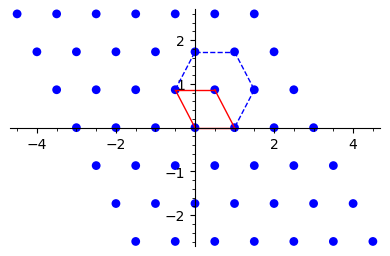

In [5]:
nudos=points([l_1*a_1/a+l_2*a_2/a for l_1 in range(-3, 4) for l_2 in range(-3,4)], 
             size=40, color="blue", frame=False)

show(nudos+
    line([(0,0),(a_1/a)],color="red")+
     line([(0,0),(a_2/a)],color="red")+
     line([(a_1/a),(a_1/a+a_2/a)],color="red")+
     line([(a_2/a),(a_2/a+a_1/a)],color="red")+
     line([(a_2/a),(a_1/a+2*a_2/a)],linestyle="--")+
     line([(a_1/a+2*a_2/a),(2*a_1/a+2*a_2/a)],linestyle="--")+
     line([(2*a_1/a+2*a_2/a),(2*a_1/a+a_2/a)],linestyle="--")+
     line([(2*a_1/a+a_2/a),(a_1/a)],linestyle="--"), figsize=4)

Para calcular los modos de vibración por primeros principios debemos determinar primero las posiciones atómicas de equilibrio en la celda unidad **nota: proporcionadas como datos**

Los átomos estan situados en:

$$
\vec R_B=\frac{1}{3}\vec{a_1}+2\vec{a_2}\qquad
\vec R_N=\frac{2}{3}\vec{a_1}+\frac{1}{3}\vec{a_2}
$$

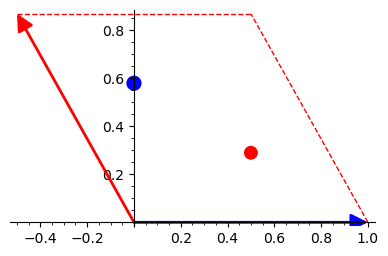

In [6]:
r_B=1/3*a_1+2/3*a_2; r_N=2/3*a_1+1/3*a_2
show(arrow((0,0),(a_1/a),color="blue")+
      arrow((0,0),(a_2/a),color="red")+
      line([(a_1/a),(a_1/a+a_2/a)],linestyle="--",color="red")+
      line([(a_2/a),(a_2/a+a_1/a)],linestyle="--",color="red")+
      point(r_B/a, size=120,color="blue")+
      point(r_N/a, size=100,color="red"), frame=False, figsize=4)

## Identificación de los vecinos segun su distáncia

Podemos dibujar los átomos en sus respectivas posiciones de equilibrio:

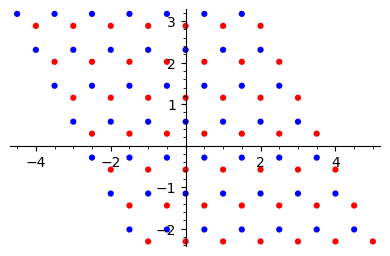

In [7]:
#Posiciones de equilibrio de los átomos
def RB(l_1,l_2):
    return (l_1*a_1+l_2*a_2+r_B)

def RN(l_1,l_2):
    return (l_1*a_1+l_2*a_2+r_N)

AtomosB=points([RB(l_1,l_2)/a for l_1 in range(-3, 4) for l_2 in range(-3,4)],size=20,color='blue')
AtomosN=points([RN(l_1,l_2)/a for l_1 in range(-3, 4) for l_2 in range(-3,4)],size=20,color='red')

show(AtomosB+AtomosN, figsize=4)

Determinamos los vecinos de los dos átomos situados en la celdilla $\vec 0$, para poder clasificarlos segun su distancia a cada uno de estos respectivos átomos.

In [8]:
import pandas as pd
var('q_x, q_y'); assume(q_x, q_y, 'real'); q=vector([q_x,q_y])


## Parametros de la red, de la celdilla y del cristal
## Vector R_l (vector de traslación primitivo)
def R_l(l_1,l_2):
    return l_1*a_1+l_2*a_2

## Vector de posición de los átomos del cristal (en equilibrio)
def R_alpha_l(alpha,l_1,l_2):
    if alpha == 1:
        return l_1*a_1+l_2*a_2+r_B

    elif alpha == 2:
        return l_1*a_1+l_2*a_2+r_N

    else:
        print("Error, alpha solo puede ser 1 o 2 ")

## Vector unitario que une uno de los átomo alphaprima con el átomo considerado alpha, l_1,l_2
def R_hat(alphaprima,alpha,l_1,l_2):
    if (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0)).norm()>0:
        return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0))/(R_alpha_l(alpha,l_1,l_2)\
                                                                 -R_alpha_l(alphaprima,0,0)).norm()
    else:
        return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0))

# Distancia entre el átomo alphaprime y su vecino alpha situado en la celdilla l_1,l_2
def distancia(alphaprime,alpha,l_1,l_2):
    return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprime,0,0)).norm()/a    

def fase(l_1,l_2):
    return exp(I*q*R_l(l_1,l_2))

#Genero una lista con la distancia de cada átomo a los átomos de la celdilla unidad 
#def valores_atomos(l_1, l_2):
#    return [(k, m, i, j, R_hat(k, m, i, j), distancia(k,m,i,j)) for k in [1,2] for m in [1,2]  \
#            for i in range(-l_1,l_1+1) for j in range(-l_2,l_2+1)]

## Construyo un DataFrame de pandas con la información necesaria para identificar a los primeros, segundos, ... vecinos, según su distancia a cada uno de los átomos de la celdilla unidad
#columnas = [r"$\alpha\prime$",r"$\alpha$",r"$l_1$", r"$l_2$", r"$\hat R$",'Distancia']

#def lista_atomos(l_1, l_2):
#    return pd.DataFrame(valores_atomos(l_1,l_2),columns=columnas).sort_values(['Distancia',r"$\alpha\prime$"], ascending=[True,True])

## Mostramos el dataframe como una tabla
#table(lista_atomos(2,2).to_html(index=False))

In [9]:
#Angulo que forma el átomo considerado respecto al eje x

def angulo(alphaprima,alpha,l_1,l_2):
    if R_hat(alphaprima,alpha,l_1,l_2)[1] <0:
        return -acos(R_hat(alphaprima,alpha,l_1,l_2)*vector([1,0]))
    
    else:
        return acos(R_hat(alphaprima,alpha,l_1,l_2)*vector([1,0]))

#Matriz unitaria de rotación para cambio de ejes coordenados (entorno al eje z)

def U(theta):
    return matrix([[cos(theta),sin(theta),0], [-sin(theta), cos(theta),0],[0,0,1]])

#Matriz de fuerza para los primeros vecinos

var('M_B,M_N', domain='positive')
var('omega')

phi1rBN=var('phi1rBN',latex_name='\\phi_{1,r}^{BN}')
phi1tiBN=var('phi1tiBN',latex_name='\\phi_{1,ti}^{BN}')
phi1toBN=var('phi1toBN',latex_name='\\phi_{1,to}^{BN}',domain='real')

phi1rNB=phi1rBN; phi1tiNB=phi1tiBN; phi1toNB=phi1toBN


Phi_10__BN=1/sqrt(M_B*M_N)*Matrix([[phi1rBN,0,0],[0,phi1tiBN,0],[0,0,phi1toBN]])
Phi_10__NB=1/sqrt(M_N*M_B)*Matrix([[phi1rNB,0,0],[0,phi1tiNB,0],[0,0,phi1toNB]])


def Phi_1l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_10__BN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_1l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_10__NB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_1l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_1l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_1l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_1l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

# Matriz de fuerza para los segundos vecinos

phi2rBB=var('phi2rBB',latex_name='\\phi_{2,r}^{BB}')
phi2tiBB=var('phi2tiBB',latex_name='\\phi_{2,ti}^{BB}')
phi2toBB=var('phi2toBB',latex_name='\\phi_{2,to}^{BB}',domain='real')

phi2rNN=var('phi2rNN',latex_name='\\phi_{2,r}^{NN}')
phi2tiNN=var('phi2tiNN',latex_name='\\phi_{2,ti}^{NN}')
phi2toNN=var('phi2toNN',latex_name='\\phi_{2,to}^{NN}',domain='real')

Phi_20__BB=1/M_B*Matrix([[phi2rBB,0,0],[0,phi2tiBB,0],[0,0,phi2toBB]])
Phi_20__NN=1/M_N*Matrix([[phi2rNN,0,0],[0,phi2tiNN,0],[0,0,phi2toNN]])

#A tener en cuenta: cuando consideramos el mismo tipo de átomos 
# (de la misma subred, no porque sean el mismmo elemento)

def Phi_2l__BB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_20__BB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_2l__NN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_20__NN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_2l_BB(alphaprima,alpha,l_1,l_2):
    return Phi_2l__BB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_2l_NN(alphaprima,alpha,l_1,l_2):
    return Phi_2l__NN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)


#Matriz de fuerza para los terceros vecinos

phi3rBN=var('phi3rBN',latex_name='\\phi_{3,r}^{BN}')
phi3tiBN=var('phi3tiBN',latex_name='\\phi_{3,ti}^{BN}')
phi3toBN=var('phi3toBN',latex_name='\\phi_{3,to}^{BN}',domain='real')
phi3rNB,phi3tiNB,phi3toNB=phi3rBN,phi3tiBN,phi3toBN
Phi_30__BN=1/sqrt(M_B*M_N)*Matrix([[phi3rBN,0,0],[0,phi3tiBN,0],[0,0,phi3toBN]])
Phi_30__NB=1/sqrt(M_N*M_B)*Matrix([[phi3rNB,0,0],[0,phi3tiNB,0],[0,0,phi3toNB]])
                   
def Phi_3l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_30__BN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_3l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_30__NB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_3l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_3l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_3l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_3l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

#Matriz de fuerza para los cuartos vecinos
phi4rBN=var('phi4rBN',latex_name='\\phi_{4,r}^{BN}')
phi4tiBN=var('phi4tiBN',latex_name='\\phi_{4,ti}^{BN}')
phi4toBN=var('phi4toBN',latex_name='\\phi_{4,to}^{BN}',domain='real')
phi4rNB,phi4tiNB,phi4toNB=phi4rBN,phi4tiBN,phi4toBN

Phi_40__BN=1/sqrt(M_B*M_N)*Matrix([[phi4rBN,0,0],[0,phi4tiBN,0],[0,0,phi4toBN]])
Phi_40__NB=1/sqrt(M_N*M_B)*Matrix([[phi4rNB,0,0],[0,phi4tiNB,0],[0,0,phi4toNB]])

def Phi_4l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_40__BN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_4l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_40__NB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_4l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_4l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_4l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_4l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

# Finalmente construimos la matriz dinámica "a capas"
# Con la tabla de la celda de codigo anterior comprobamos que para considerar 
# hasta los cuartos vecinos es suficiente con l_1,l_2=2
                   
D1BN, D1NB, D2BB, D2NN, D3BN, D3NB, D4BN, D4NB = (matrix(3) for i in range(8))
D01BN, D01NB, D02BB, D02NN, D03BN, D03NB, D04BN, D04NB= (matrix(3) for i in range(8))
for k in [1,2]:
    for m in [1,2]:
         for i in range(-2,3):
            for j in range(-2,4):
                if (k==1) & bool( distancia(k,m,i,j) == sqrt(3)/3 ):
                    D1BN += D_1l_BN(k,m,i,j)
                    D01BN += Phi_1l__BN(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == sqrt(3)/3 ):
                    D1NB += D_1l_NB(k,m,i,j)
                    D01NB += Phi_1l__NB(k,m,i,j)
                 
                elif (k==1) & bool( distancia(k,m,i,j) == 1):
                    D2BB += D_2l_BB(k,m,i,j)
                    D02BB += Phi_2l__BB(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == 1):
                    D2NN += D_2l_NN(k,m,i,j)
                    D02NN += Phi_2l__NN(k,m,i,j)

                elif (k==1) & bool( distancia(k,m,i,j) == 2*sqrt(3)/3 ):
                    D3BN += D_3l_BN(k,m,i,j)
                    D03BN += Phi_3l__BN(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == 2*sqrt(3)/3 ):
                    D3NB += D_3l_NB(k,m,i,j)
                    D03NB += Phi_3l__NB(k,m,i,j)
                    
                elif (k==1) & bool( distancia(k,m,i,j) == sqrt(7/3)):
                    D4BN += D_4l_BN(k,m,i,j)
                    D04BN += Phi_4l__NB(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == sqrt(7/3)):
                    D4NB += D_4l_NB(k,m,i,j)
                    D04NB += Phi_4l__NB(k,m,i,j)

# Tenemos en cuenta la contribución a la matriz dinámica de los átomos situados en 
# la celdilla 0
D2BB=D2BB-D01BN-D02BB-D03BN
D2NN=D2NN-D01NB-D02NN-D03NB                    

### Unas simples comprobaciones para comprobar que he definido bien los tensores de fuerza y las matrices dinámicas:
(Comparando la matriz dinámica para los primeros vecinos del boro con las obtenidas "manualmente")

In [10]:
D_1l_BN(1,2,-1,0)+D_1l_BN(1,2,0,0)+D_1l_BN(1,2,0,1)-D1BN

[0 0 0]
[0 0 0]
[0 0 0]

## Vamos a fijarnos sólo en las vibraciones transversales fuera de plano
Puesto que las vibraciones fuera de plano son, por cómo hemos constuido la matriz dinámica, independientes de las interplanares, podemos estudiar primero las vibraciones fuera de plano


In [11]:
D1BN_zz=D1BN[2,2]
D1NB_zz=D1NB[2,2]

D2BB_zz=D2BB[2,2]
D2NN_zz=D2NN[2,2]

D3BN_zz=D3BN[2,2]
D3NB_zz=D3NB[2,2]
D4BN_zz=D4BN[2,2]
D4NB_zz=D4NB[2,2]

#D_zz=Matrix([[D2BB_zz,D1BN_zz+D3BN_zz+D4BN_zz], [D1NB_zz+D3NB_zz+D4BN_zz,D2NN_zz]])
D_zz=Matrix([[D2BB_zz,D1BN_zz+D3BN_zz], [D1NB_zz+D3NB_zz,D2NN_zz]])

#valors_propis_D_zz=D_zz.eigenvalues()
D_zz[0,0].simplify_full()

(4*M_N*phi2toBB*cos(1/2*sqrt(3)*a*q_y)*cos(1/2*a*q_x) + 2*M_N*phi2toBB*cos(a*q_x) - 6*M_N*phi2toBB - 3*sqrt(M_B*M_N)*(phi1toBN + phi3toBN))/(M_B*M_N)

### Para el punto $\Gamma (k_x=0, k_y=0)$

In [12]:
from periodictable import C, B, N, constants
u=constants.atomic_mass_constant*10**3 #para que este en CGS (y las const. de fuerza en dyn)

omega_Gamma_ZO=830 #cm-1
omega_Gamma_ZA=0

D_Gamma_zz=D_zz.subs(q_x=0,q_y=0) #,(M_B,B.mass*u),(M_N,N.mass*u)])
D_Gamma_zz

[-3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N)  3*phi1toBN/sqrt(M_B*M_N) + 3*phi3toBN/sqrt(M_B*M_N)]
[ 3*phi1toBN/sqrt(M_B*M_N) + 3*phi3toBN/sqrt(M_B*M_N) -3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N)]

In [13]:
D_Gamma_zz.eigenvalues()

[-6*(phi1toBN + phi3toBN)/sqrt(M_B*M_N), 0]

In [14]:
Eq1=(D_Gamma_zz.eigenvalues()[0]==omega**2).subs(omega=omega_Gamma_ZO)
#timeit('Eq1=solve(det(D_Gamma_zz-omega**2)==0, omega)')#.subs(omega=omega_Gamma_ZO)
Eq1

-6*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) == 688900

In [15]:
solEq1=solve(Eq1, phi3toBN); solEq1[0]

phi3toBN == -phi1toBN - 344450/3*sqrt(M_B*M_N)

### Para el punto $K$ ($k_x=4\pi/(3 a)$, $k_y=0$)

In [16]:
omega_K_ZO=605 #cm-1
omega_K_ZA=322
D_K_zz=D_zz.subs(q_x=4*pi/(3*a),q_y=0)
D_K_zz.eigenvalues()
#solve(det(D_K_zz-omega**2)==0, omega**2)

[-3*(M_N*phi1toBN + M_N*phi3toBN + 3*sqrt(M_B*M_N)*phi2toNN)/(sqrt(M_B*M_N)*M_N),
 -3*(M_B*phi1toBN + M_B*phi3toBN + 3*sqrt(M_B*M_N)*phi2toBB)/(sqrt(M_B*M_N)*M_B)]

Podemos observar que en el baso del $BN$, a diferencia del caso del grafeno, obtenemos 2 frecuencias distintas en el punto $K$ debido a que en la base tenemos dos átomos distintos.

In [17]:
sol=[]
Eq2=(D_K_zz.eigenvalues()[0]==omega**2).subs(omega=omega_K_ZO)
Eq3=(D_K_zz.eigenvalues()[1]==omega**2).subs(omega=omega_K_ZA)
sol.append(solve(Eq2.subs(solEq1),phi2toNN)[0])
sol.append(solve(Eq3.subs(solEq1),phi2toBB)[0])
sol

[phi2toNN == -21575/9*M_N, phi2toBB == 240766/9*M_B]

### Y para el punto $M(q_x=\pi/a,q_y=\pi/(\sqrt 3 a)$

In [18]:
omega_M_ZO=635 #cm-1
omega_M_ZA=314

D_M_zz=D_zz.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a))
#D_M_zz.eigenvalues()

Podemos simplificar un poco la expresión obtenida para los valores propios en el punto $M$ (simplemente reescribiendo el argumento de la raiz cuadrada)

In [19]:
omegaM1cuadrado=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN)-sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2)/(M_B*M_N)
if bool(D_M_zz.eigenvalues()[0]==omegaM1cuadrado):
    show(omegaM1cuadrado)

-3*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N - sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N)

In [20]:
omegaM2cuadrado=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN)+sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2)/(M_B*M_N)
if bool(D_M_zz.eigenvalues()[1]==omegaM2cuadrado):
    show(omegaM2cuadrado)

-3*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N + sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N)

Podemos comprobar que en el caso que fuesen los átomos identicos obtenemos las mismas expresiones que en Falkowsky

In [21]:
D_M_zz.subs(M_B=M_N, phi2toBB=phi2toNN).eigenvalues()

[-2*(phi1toBN + 4*phi2toNN + 3*phi3toBN)/M_N, -4*(phi1toBN + 2*phi2toNN)/M_N]

In [22]:
Eq5=(omegaM1cuadrado==omega_M_ZO**2)
Eq6=(omegaM2cuadrado==omega_M_ZA**2)
#sol.append(solve(((Eq5-Eq6)**2).subs(sol[0], sol[1], solEq1[0],M_N=N.mass, M_B=B.mass), phi1toBN)[1])

In [23]:
sol1=(phi1toBN==n(solve(((Eq6-Eq5)**2).subs(solEq1), phi1toBN)[0].subs(sol[0], sol[1]).subs(M_B=B.mass, \
    M_N=N.mass).rhs()))
sol1

phi1toBN == -1.36116402436406e6

In [24]:
sol2=sol[0].subs(M_N=N.mass)
sol2

phi2toNN == -33577.1725

In [25]:
sol3=sol[1].subs(M_B=B.mass)
sol3

phi2toBB == 289213.46955555555

In [26]:
sol4=solEq1[0].subs(M_B=B.mass, M_N=N.mass).subs(sol1)
sol4

phi3toBN == -51717.6151722642

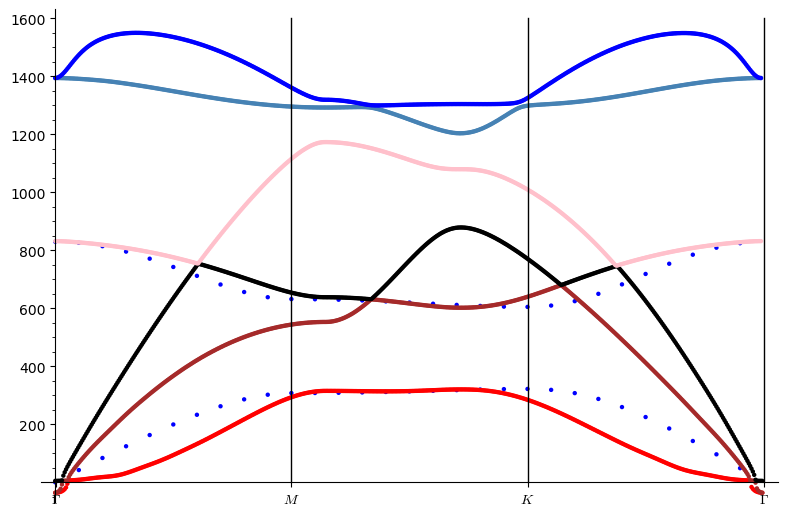

CPU times: user 49.6 s, sys: 710 ms, total: 50.3 s
Wall time: 49.2 s


In [27]:
%%time
from pylab import loadtxt
data = pd.read_csv('../Dades/freq.dat', header = None)
dades=loadtxt("../Dades/freq.dat")
show(\
list_plot(
    [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(x*pi), q_y=n(x*pi/sqrt(3))).simplify_full().eigenvalues()[1]))) \
        for x in srange(0,1,0.1)] +\
         [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
M_N=N.mass, a=1, q_x=n(pi*(1+x/3)), q_y=n(pi/sqrt(3)*(1-x))).simplify_full().eigenvalues()[1]))) \
        for x in srange(0,1,0.1)]+\
         [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
M_N=N.mass, a=1, q_x=n(4*pi/3*(1-x)), q_y=0).simplify_full().eigenvalues()[1]))) \
        for x in srange(0,1,0.1)]) + \
list_plot(
    [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(x*pi), q_y=n(x*pi/sqrt(3))).simplify_full().eigenvalues()[0]))) \
        for x in srange(0,1,0.1)]+
          [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
M_N=N.mass, a=1,q_x=n(pi*(1+x/3)), q_y=n(pi/sqrt(3)*(1-x))).simplify_full().eigenvalues()[0]))) \
        for x in srange(0,1,0.1)]+\
         [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
M_N=N.mass, a=1, q_x=n(4*pi/3*(1-x)), q_y=0).simplify_full().eigenvalues()[0]))) \
        for x in srange(0,1,0.1)]) \
     +line([(10,0),(10,1600)], color="black")+line([(20,0),(20,1600)], color="black")\
     +line([(30,0),(30,1600)], color="black", ticks=[[0.05,10,20,30], None], \
        tick_formatter = [[r'$\Gamma$', '$M$', '$K$', r'$\Gamma$'], None])+\
points(zip(dades[:524,0]/524*30, dades[:524,1]), color="red") +\
points(zip(dades[524:1048,0]/524*30, dades[524:1048,1]), color="brown") +\
points(zip(dades[1048:1572,0]/524*30, dades[1048:1572,1]), color="black") +\
points(zip(dades[1572:2096,0]/525*30, dades[1572:2096,1]), color="pink") +\
points(zip(dades[2096:2620,0]/525*30, dades[2096:2620,1]), color="steelblue") +\
points(zip(dades[2620:3144,0]/525*30, dades[2620:3144,1]), color="blue")     
     ,figsize=8) 

In [28]:
%%time
n(real_part(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
M_N=N.mass, a=1, q_x=pi*(4/3), q_y=0).simplify_full().eigenvalues()[1])))

CPU times: user 272 ms, sys: 4.02 ms, total: 276 ms
Wall time: 274 ms


605.000000000000

# Para la vibraciones interplanares

In [29]:
D1BN_xy=D1BN.matrix_from_rows_and_columns([0,1],[0,1])
D1NB_xy=D1NB.matrix_from_rows_and_columns([0,1],[0,1])

D2BB_xy=D2BB.matrix_from_rows_and_columns([0,1],[0,1])
D2NN_xy=D2NN.matrix_from_rows_and_columns([0,1],[0,1])
               
D3BN_xy=D3BN.matrix_from_rows_and_columns([0,1],[0,1])
D3NB_xy=D3NB.matrix_from_rows_and_columns([0,1],[0,1])
#D4BN_xy=D4BN.matrix_from_rows_and_columns([0,1],[0,1])
#D4NB_xy=D4NB.matrix_from_rows_and_columns([0,1],[0,1])


In [30]:
D_xy=block_matrix([[D2BB_xy, D1BN_xy+D3BN_xy],[D1NB_xy+D3NB_xy, D2NN_xy]])

### Para el punto $\Gamma (k_x=0, k_y=0)$

In [31]:
D_Gamma_xy=D_xy.subs(q_x=0,q_y=0)

In [32]:
D_Gamma_xy.eigenvalues()

[-3*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN)/sqrt(M_B*M_N),
 -3*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN)/sqrt(M_B*M_N),
 0,
 0]

Observerm que obtenim 2 valors propis (de multiplicitat $2$ cadascun d'ells)
Obtenim 0 dues vegades, tal i com tenim en les dades propocionades.
L'altre valor propi també correspon a dues rames, com en les dades.
Així que podem escriure

In [33]:
omega_Gamma_5=1395
Eq_Gamma_5=(D_Gamma_xy.eigenvalues()[0]==omega_Gamma_5**2)
Eq_Gamma_5

-3*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN)/sqrt(M_B*M_N) == 1946025

## Nota: per als punts $K$ i $M$, no obtenim una expressió anaítica com fins ara
però obtinc els valors propis supossant que en compte de una base diatòmica amb 2 àtoms de diferents elements tenim una base amb els dos àtoms iguals (supossem que les dues masses son iguals i que les constants de forca entre átoms del mateix element (segons veïns) són iguals també. 

Evidentment els resultats obtessos no són vàlids, però els emprarem com a punt de partida per poder trobar el valor de les constants de forca ajustant als valors proporcionats. De fet, obtenim una expressió analítica igualant sols una d'estes forces (les $r$ o $ti$)

### Per al punto $K (k_x=\frac{4\pi}{3a}, k_y=0)$

In [34]:
D_K_xy=matriu_simplificada(D_xy.subs(q_x=4*pi/(3*a),q_y=0),4,4)

In [35]:
D_K_xy_0=D_xy.subs(q_x=4*pi/(3*a),q_y=0,phi2rNN=phi2rBB,phi2tiNN=phi2tiBB, M_N=M_B)
D_K_xy_0.eigenvalues()

[-3/2*(2*phi1tiBN + 3*phi2rBB + 3*phi2tiBB + 2*phi3tiBN)/M_B,
 -3/2*(2*phi1rBN + 3*phi2rBB + 3*phi2tiBB + 2*phi3rBN)/M_B,
 -3/2*(phi1rBN + phi1tiBN + 3*phi2rBB + 3*phi2tiBB + phi3rBN + phi3tiBN)/M_B,
 -3/2*(phi1rBN + phi1tiBN + 3*phi2rBB + 3*phi2tiBB + phi3rBN + phi3tiBN)/M_B]

In [36]:
bool(D_K_xy_0.eigenvalues()[2]==D_K_xy_0.eigenvalues()[3])

True

Al punt $K$ obtenim 3 valors propis distints.
Si no emprem tantes simplificacions:

In [37]:
D_K_xy_1=D_xy.subs(q_x=4*pi/(3*a),q_y=0,phi2rNN=phi2rBB, M_N=M_B)
D_K_xy_1.eigenvalues()

[-3/2*(phi1rBN + phi1tiBN + 3*phi2rBB + 3*phi2tiNN + phi3rBN + phi3tiBN)/M_B,
 -3/2*(phi1rBN + phi1tiBN + 3*phi2rBB + 3*phi2tiBB + phi3rBN + phi3tiBN)/M_B,
 -3/4*(2*phi1rBN + 2*phi1tiBN + 6*phi2rBB + 3*phi2tiBB + 3*phi2tiNN + 2*phi3rBN + 2*phi3tiBN + sqrt(4*phi1rBN^2 - 8*phi1rBN*phi1tiBN + 4*phi1tiBN^2 + 9*phi2tiBB^2 - 18*phi2tiBB*phi2tiNN + 9*phi2tiNN^2 + 8*(phi1rBN - phi1tiBN)*phi3rBN + 4*phi3rBN^2 - 8*(phi1rBN - phi1tiBN + phi3rBN)*phi3tiBN + 4*phi3tiBN^2))/M_B,
 -3/4*(2*phi1rBN + 2*phi1tiBN + 6*phi2rBB + 3*phi2tiBB + 3*phi2tiNN + 2*phi3rBN + 2*phi3tiBN - sqrt(4*phi1rBN^2 - 8*phi1rBN*phi1tiBN + 4*phi1tiBN^2 + 9*phi2tiBB^2 - 18*phi2tiBB*phi2tiNN + 9*phi2tiNN^2 + 8*(phi1rBN - phi1tiBN)*phi3rBN + 4*phi3rBN^2 - 8*(phi1rBN - phi1tiBN + phi3rBN)*phi3tiBN + 4*phi3tiBN^2))/M_B]

In [38]:
bool(D_K_xy_0.eigenvalues()[2]==D_K_xy_1.eigenvalues()[1])

True

Al punt $K$ obtenim 3 valors propis, un d'ell degenerat, cosa que s'aproxima prou a la descripció qualitativa observada en la gràfica (les dues freqüències més altes estan prou proximes).

Realitzant altres simplificacions podem calcular dos valors propis de la matriu dinàmica, que corresponen justament al valor propi que en primera aproximació ens ix degenerat:

In [39]:
D_K_xy_2=D_xy.subs(q_x=4*pi/(3*a),q_y=0,phi2tiNN=phi2tiBB, M_N=M_B)
D_K_xy_2.eigenvalues()

[-3/2*(phi1rBN + phi1tiBN + 3*phi2rNN + 3*phi2tiBB + phi3rBN + phi3tiBN)/M_B,
 -3/2*(phi1rBN + phi1tiBN + 3*phi2rBB + 3*phi2tiBB + phi3rBN + phi3tiBN)/M_B,
 -3/4*(2*phi1rBN + 2*phi1tiBN + 3*phi2rBB + 3*phi2rNN + 6*phi2tiBB + 2*phi3rBN + 2*phi3tiBN + sqrt(4*phi1rBN^2 - 8*phi1rBN*phi1tiBN + 4*phi1tiBN^2 + 9*phi2rBB^2 - 18*phi2rBB*phi2rNN + 9*phi2rNN^2 + 8*(phi1rBN - phi1tiBN)*phi3rBN + 4*phi3rBN^2 - 8*(phi1rBN - phi1tiBN + phi3rBN)*phi3tiBN + 4*phi3tiBN^2))/M_B,
 -3/4*(2*phi1rBN + 2*phi1tiBN + 3*phi2rBB + 3*phi2rNN + 6*phi2tiBB + 2*phi3rBN + 2*phi3tiBN - sqrt(4*phi1rBN^2 - 8*phi1rBN*phi1tiBN + 4*phi1tiBN^2 + 9*phi2rBB^2 - 18*phi2rBB*phi2rNN + 9*phi2rNN^2 + 8*(phi1rBN - phi1tiBN)*phi3rBN + 4*phi3rBN^2 - 8*(phi1rBN - phi1tiBN + phi3rBN)*phi3tiBN + 4*phi3tiBN^2))/M_B]

In [40]:
D_K_xy_3=D_xy.subs(q_x=4*pi/(3*a),q_y=0,phi3rBN=phi3tiBN, M_N=M_B)
D_K_xy_3.eigenvalues()

[-3/2*(phi1rBN + phi1tiBN + 3*phi2rNN + 3*phi2tiNN + 2*phi3tiBN)/M_B,
 -3/2*(phi1rBN + phi1tiBN + 3*phi2rBB + 3*phi2tiBB + 2*phi3tiBN)/M_B,
 -3/4*(2*phi1rBN + 2*phi1tiBN + 3*phi2rBB + 3*phi2rNN + 3*phi2tiBB + 3*phi2tiNN + 4*phi3tiBN + sqrt(4*phi1rBN^2 - 8*phi1rBN*phi1tiBN + 4*phi1tiBN^2 + 9*phi2rBB^2 - 18*phi2rBB*phi2rNN + 9*phi2rNN^2 + 18*(phi2rBB - phi2rNN)*phi2tiBB + 9*phi2tiBB^2 - 18*(phi2rBB - phi2rNN + phi2tiBB)*phi2tiNN + 9*phi2tiNN^2))/M_B,
 -3/4*(2*phi1rBN + 2*phi1tiBN + 3*phi2rBB + 3*phi2rNN + 3*phi2tiBB + 3*phi2tiNN + 4*phi3tiBN - sqrt(4*phi1rBN^2 - 8*phi1rBN*phi1tiBN + 4*phi1tiBN^2 + 9*phi2rBB^2 - 18*phi2rBB*phi2rNN + 9*phi2rNN^2 + 18*(phi2rBB - phi2rNN)*phi2tiBB + 9*phi2tiBB^2 - 18*(phi2rBB - phi2rNN + phi2tiBB)*phi2tiNN + 9*phi2tiNN^2))/M_B]

In [41]:
D_K_xy_3.eigenvalues()[]

SyntaxError: invalid syntax (<ipython-input-41-1c1248386a7e>, line 1)

In [ ]:
D_K_xy_4=D_xy.subs(q_x=4*pi/(3*a),q_y=0,phi1rBN=phi1tiBN,phi2rNN=phi2rBB,phi2tiNN=phi2tiBB,phi3tiBN=0,phi3rBN=0)
#D_K_xy_4.eigenvalues()

In [ ]:
valor_en_K_1=-3/2*(phi1rBN+phi1tiBN+phi3rBN+phi3tiBN)/sqrt(M_B*M_N)-9/2*(phi2rNN+phi2tiNN)/M_N
valor_en_K_1

In [ ]:
valor_en_K_2=-3/2*(phi1rBN+phi1tiBN+phi3rBN+phi3tiBN)/sqrt(M_B*M_N)-9/2*(phi2rBB+phi2tiBB)/M_B
valor_en_K_2

In [ ]:
[det(D_K_xy-valor_en_K_1),det(D_K_xy-valor_en_K_2)]

Per altra banda, intentem calcula la suma dels dos altres valors propis:

In [ ]:
[D_K_xy_1.eigenvalues()[2]+D_K_xy_1.eigenvalues()[3]][0].full_simplify()

In [ ]:
[D_K_xy_2.eigenvalues()[2]+D_K_xy_2.eigenvalues()[3]][0].full_simplify()

In [ ]:
(D_K_xy_3.eigenvalues()[2]+D_K_xy_3.eigenvalues()[3]).full_simplify()

In [ ]:
(D_K_xy_3.eigenvalues()[0]+D_K_xy_3.eigenvalues()[1]).full_simplify()

In [ ]:
suma_de_valors_propis_2_i_3=-3/sqrt(M_B*M_N)*(phi1rBN+phi1tiBN+phi3rBN+phi3tiBN)
suma_de_valors_propis_2_i_3

In [ ]:
omega_K_5=1299
Eq_K_5=(D_K_xy.eigenvalues()[2]==omega_K_5**2)
Eq_K_5

In [ ]:
omega_K_6=1326 
Eq_K_6=(D_K_xy.eigenvalues()[1]==omega_K_6**2) ## suposse que 1r es major que ninguna
Eq_K_6

In [ ]:
omega_K_4=1009 
Eq_K_4=(D_K_xy.eigenvalues()[0]==omega_K_4**2) ## suposse que 1r es major que ninguna
Eq_K_4

In [ ]:
(2*Eq_K_5-Eq_K_6).factor()-Eq_K_4

In [ ]:
solve(Eq_Gamma_5, phi1rBN)

In [ ]:
(2*Eq_K_5-Eq_K_6).factor()

In [ ]:
solve((Eq_K_5-Eq_K_4).factor(), phi1rBN)[0]

In [ ]:
solve((Eq_K_5-Eq_K_4).factor(), phi1rBN)[0].rhs().subs(M_B=sqrt(M_B*M_N))-solve(Eq_Gamma_5, phi1rBN)[0].rhs()

In [ ]:
solve((Eq_K_5-Eq_K_6).factor(), phi1rBN)[0].rhs().subs(M_B=sqrt(M_B*M_N))-solve(Eq_Gamma_5, phi1rBN)[0].rhs()

Emprant les equacions per ara porde aproxima $\phi_{1,r}^{BN}\approx\phi_{3,r}^{BN}-225000\sqrt{M_B M_N}$ i $\phi_{1,ti}^{BN}\approx-\phi_{3,ti}^{BN}-200000\sqrt{M_B M_N}$

### Y para el punto $M(q_x=\pi/a,q_y=\pi/(\sqrt{3} a)$

In [ ]:
D_M_xy=matriu_simplificada(D_xy.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a)),4,4)
#D_M_xy.charpoly()

In [ ]:
#D_M_xy[1,1]

In [ ]:
#D_M_xy[2,2]

In [ ]:
#D_M_xy[3,3]

In [ ]:
#omega_M_ZO=635 #cm-1
#omega_M_ZA=314
D_M_xy_0=D_xy.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a), phi2rNN=phi2rBB,phi2tiNN=phi2tiBB,M_N=M_B)
D_M_xy_0.eigenvalues()

Al punt $M$ sí obtenim  4 valors propis diferents. Cosa que sembla raonable observant la gràfica de les dades proporcionades.

Passem ara a determinar, en una primera aproximació estes constants (encara que sabem que no tenen perque eixir valors masa bons, doncs hem simplificat molt el nostre problema).

In [ ]:
D_M_xy_1=D_xy.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a), phi2rNN=phi2rBB,phi2tiNN=phi2tiBB,phi3tiBN=phi3rBN)